In [ ]:
# TMDB 데이터 경로
import pandas as pd
path_tmdb = "/root/own_cinema/datasss/TMDB_all_movies.csv"

# 데이터 읽기
df = pd.read_csv(path_tmdb)

# 제거할 열 리스트
columns_to_drop = [
    'vote_count', 'revenue', 'budget', 'original_title', 
    'production_companies', 'production_countries', 
    'director_of_photography', 'producers', 'music_composer',
    'imdb_votes','poster_path','imdb_rating','spoken_languages','id','imdb_id'
]

# 열 제거
df_cleaned = df.drop(columns=columns_to_drop)

# 'status'가 'Released'가 아닌 행 제거
df_cleaned = df_cleaned[df_cleaned['status'] == 'Released']

# 'release_date'에서 연도만 추출 후 기존 열 삭제
df_cleaned['release_year'] = pd.to_datetime(df_cleaned['release_date'], errors='coerce').dt.year.astype('Int64')
df_cleaned = df_cleaned.drop(columns=['release_date'])

# 'status' 열 제거
df_cleaned = df_cleaned.drop(columns=['status'])

# 'title' 없으면 제거
df_cleaned = df_cleaned.dropna(subset=['title'])

# 하위 40%의 popularity와 vote_average 제거
popularity_threshold = df_cleaned['popularity'].quantile(0.4)
vote_average_threshold = df_cleaned['vote_average'].quantile(0.4)

df_cleaned = df_cleaned[
    (df_cleaned['popularity'] > popularity_threshold) & 
    (df_cleaned['vote_average'] > vote_average_threshold)
]

# popularity와 vote_average 열 제거
df_cleaned = df_cleaned.drop(columns=['popularity', 'vote_average'])

# 결과 확인
print(df_cleaned.head())
print(df_cleaned.isnull().sum())

In [3]:
# relation checking
import pandas as pd

# 파일 경로
path_tags = "/root/own_cinema/datasss/new_dataset/ml-32m/tags.csv"
path_ratings = "/root/own_cinema/datasss/new_dataset/ml-32m/ratings.csv"

# 데이터 읽기
df_tags = pd.read_csv(path_tags)
df_ratings = pd.read_csv(path_ratings)

# 결측치가 있는 행 제거 및 timestamp 제거
df_tags_cleaned = df_tags.dropna(subset=['tag']).drop(columns=['timestamp'])
df_ratings_cleaned = df_ratings.drop(columns=['timestamp'])

# userId와 movieId 기준으로 병합
merged_df = pd.merge(
    df_ratings_cleaned,
    df_tags_cleaned,
    on=['userId', 'movieId'],
    how='left'  # rating이 없는 경우 tag를 추가하지 않음
)

# tag가 NaN인 행 제거
merged_df_cleaned = merged_df.dropna(subset=['tag'])

# 결과 확인
print(merged_df_cleaned.head())
print(f"제거 후 크기: {merged_df_cleaned.shape}")

      userId  movieId  rating           tag
2208      22    26479     3.5   Kevin Kline
2238      22   247150     3.0    acrophobia
5978      34     2174     4.0         music
5979      34     2174     4.0         weird
6026      34     8623     4.0  Steve Martin
제거 후 크기: (1439939, 4)


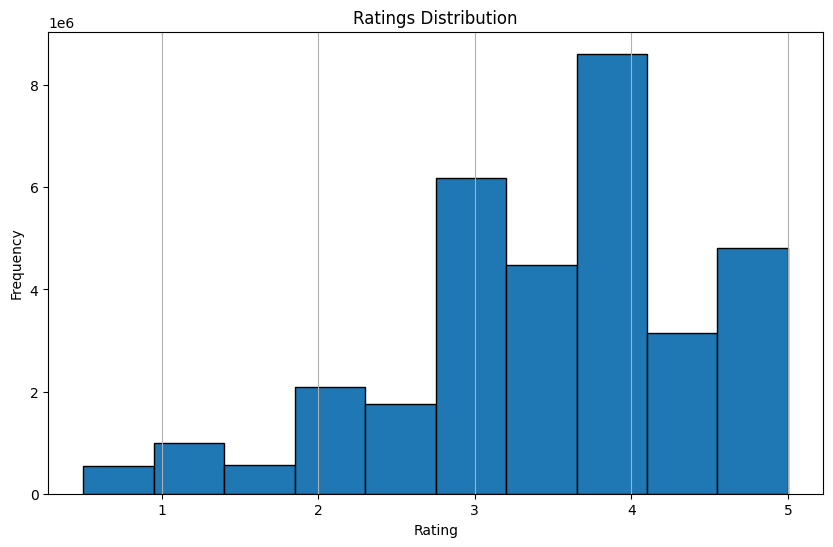

In [ ]:
#Ratings 의 분포 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
merged_df['rating'].hist(bins=10, edgecolor='black')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

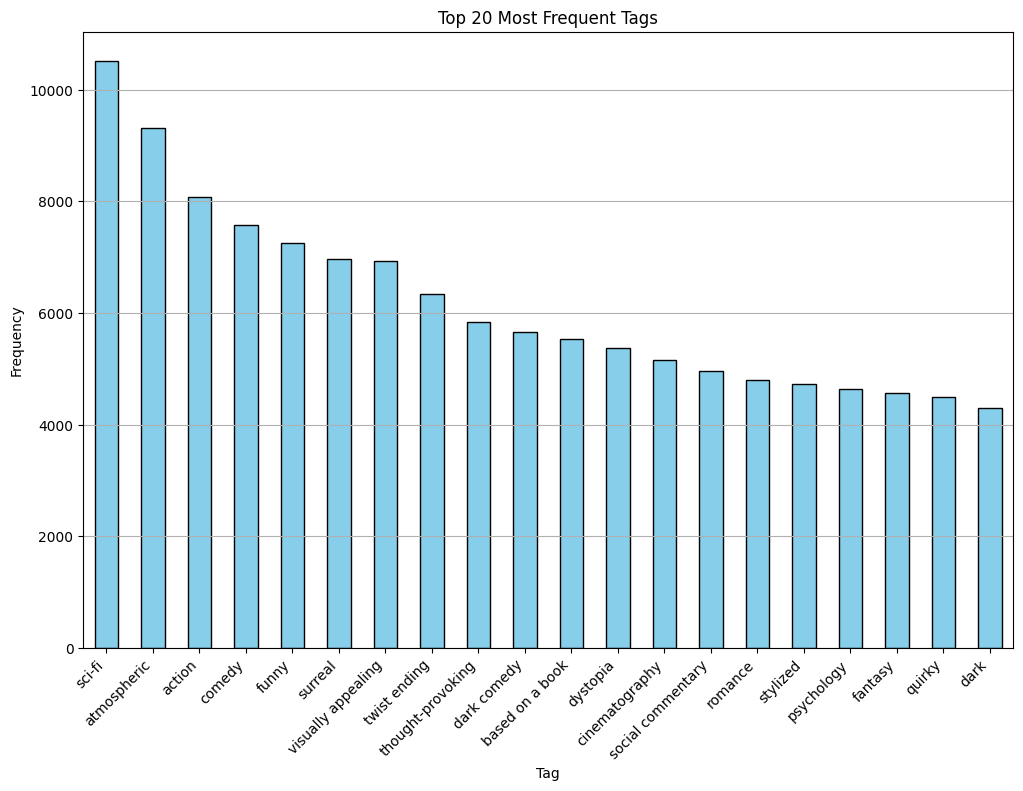

In [ ]:
#TAG의 빈도 확인인
tag_counts = merged_df['tag'].value_counts().head(20)  # 상위 20개 태그
plt.figure(figsize=(12, 8))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Most Frequent Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

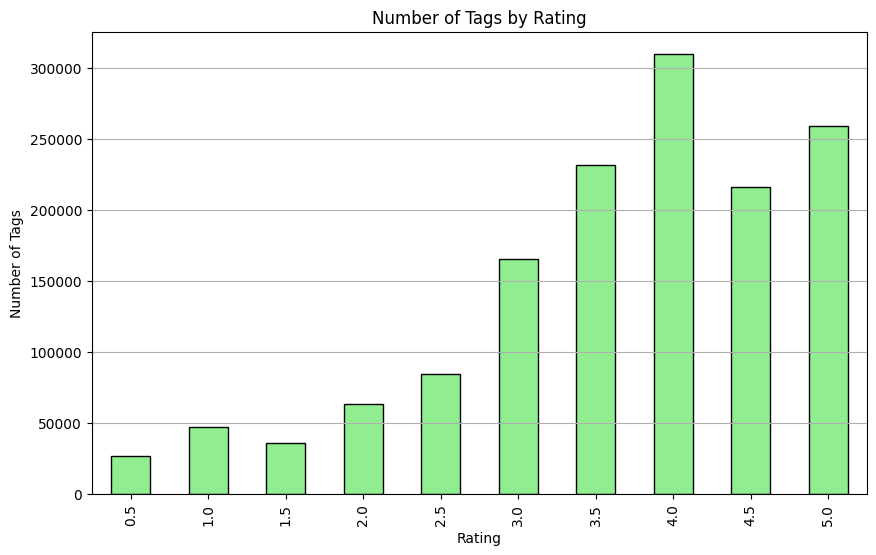

In [ ]:
#Ratings와 Tag의 관계
# 평점별 태그 수 분석
rating_tag_counts = merged_df.groupby('rating')['tag'].count()

# 시각화
plt.figure(figsize=(10, 6))
rating_tag_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Number of Tags by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Tags')
plt.grid(axis='y')
plt.show()


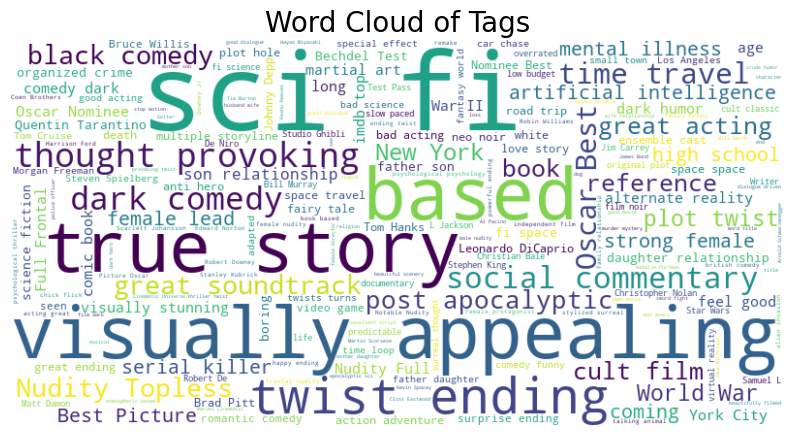

In [ ]:
#Tag의 word cloud
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 태그 데이터 준비 (NaN 제거)
tags = merged_df['tag'].dropna()

# 모든 태그를 하나의 문자열로 연결
text = ' '.join(tags)

# 워드 클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='viridis'
).generate(text)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags', fontsize=20)
plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 태그 인코딩
tag_encoder = LabelEncoder()
merged_df_cleaned['tag_encoded'] = tag_encoder.fit_transform(merged_df_cleaned['tag'])

# 입력 변수 (userId와 tag)와 종속 변수 (rating) 분리
X = merged_df_cleaned[['userId', 'tag_encoded']]
y = merged_df_cleaned['rating']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipykernel_20105/1958318141.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['tag_encoded'] = tag_encoder.fit_transform(merged_df_cleaned['tag'])


In [9]:
import statsmodels.api as sm

# 상수항 추가 (절편)
X_train_with_const = sm.add_constant(X_train)

# OLS 회귀 모델 적합
model = sm.OLS(y_train, X_train_with_const).fit()

# 모델 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     994.5
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:51:52   Log-Likelihood:            -1.7576e+06
No. Observations:             1151951   AIC:                         3.515e+06
Df Residuals:                 1151948   BIC:                         3.515e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.6645      0.003   1246.964      

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 모델 생성 및 학습
reg = LinearRegression()
reg.fit(X_train, y_train)

# 예측
y_pred = reg.predict(X_test)

# 모델 평가
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred):.2f}")

# 회귀 계수
print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)


Mean Squared Error: 1.24
R-squared: 0.00
Coefficients: [ 6.94528810e-07 -1.19251563e-06]
Intercept: 3.6645449887382524


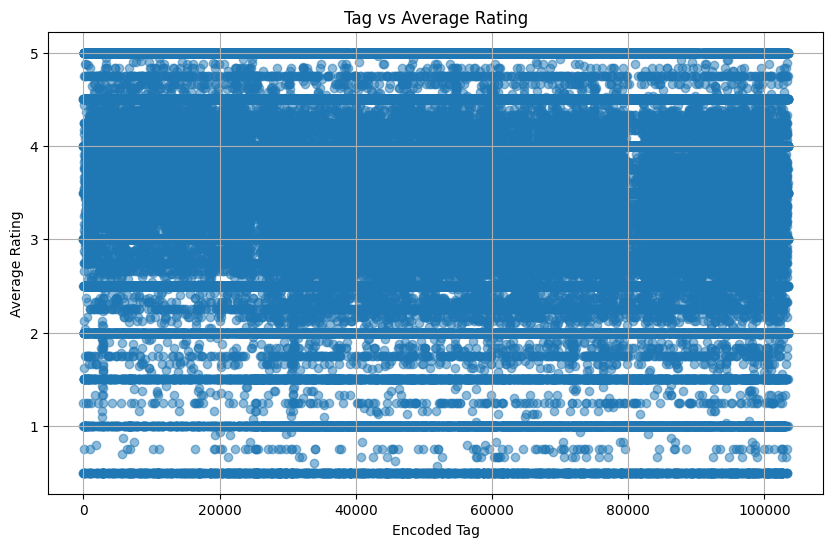

In [11]:
import matplotlib.pyplot as plt

# 태그별 평균 평점 계산
tag_avg_rating = merged_df_cleaned.groupby('tag_encoded')['rating'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(tag_avg_rating['tag_encoded'], tag_avg_rating['rating'], alpha=0.5)
plt.title('Tag vs Average Rating')
plt.xlabel('Encoded Tag')
plt.ylabel('Average Rating')
plt.grid()
plt.show()

#결론 : 태그(tag)가 평점(rating)에 유의미한 영향을 미친다고 볼 수 없다
# 기록 : 값이 0.002이므로, userId와 tag_encoded 변수로는 rating의 변동을 거의 설명하지 못합니다..

In [ ]:
# "통계적으로 같은 유저라면 특정 태그를 가진 영화를 더 rating 높게 줄 것이다" 라는 가설 검정
# 유저별로 태그와 평점 데이터 그룹화
user_tag_rating = merged_df_cleaned.groupby(['userId', 'tag'])['rating'].mean().reset_index()

# 결과 확인
print(user_tag_rating.head())


   userId           tag  rating
0      22   Kevin Kline     3.5
1      22    acrophobia     3.0
2      34  Steve Martin     4.0
3      34         music     4.0
4      34         weird     4.0


In [13]:
from scipy.stats import pearsonr

# 유저별 태그-평점 상관관계 계산
user_correlation = []

for user_id, group in user_tag_rating.groupby('userId'):
    if len(group['tag']) > 1:  # 태그가 2개 이상 있어야 상관관계 계산 가능
        corr, _ = pearsonr(group['tag'].astype(str).str.len(), group['rating'])
        user_correlation.append({'userId': user_id, 'correlation': corr})

# 결과 데이터프레임
correlation_df = pd.DataFrame(user_correlation)

# 상관관계 평균 확인
print(correlation_df['correlation'].mean())


/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: Con

0.01050206796225217


/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/root/anaconda3/envs/new/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: Con

In [14]:
import statsmodels.formula.api as smf

# 태그를 고정 효과, 유저를 랜덤 효과로 설정
model = smf.mixedlm("rating ~ tag_encoded", merged_df_cleaned, groups=merged_df_cleaned["userId"])
result = model.fit()

# 모델 결과 출력
print(result.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rating       
No. Observations: 1439939 Method:             REML         
No. Groups:       14543   Scale:              0.8954       
Min. group size:  1       Log-Likelihood:     -1976847.6974
Max. group size:  258775  Converged:          Yes          
Mean group size:  99.0                                     
------------------------------------------------------------
             Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    4.142     0.006  641.760  0.000   4.129   4.154
tag_encoded  0.000     0.000    0.598  0.550  -0.000   0.000
Group Var    0.399     0.007                                



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상위 50개 태그 선택
top_tags = user_tag_rating['tag'].value_counts().head(50).index
filtered_data = user_tag_rating[user_tag_rating['tag'].isin(top_tags)]

# 상위 태그 데이터로 시각화
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_data, x='tag', y='rating')
plt.title('User-specific Tag Rating Distribution (Top Tags)')
plt.xticks(rotation=45, ha='right')
plt.show()

#결론 : tag_encoded의 고정 효과가 유의미하지 않아, 태그가 평점에 영향을 미친다고 볼 수 없다.

NameError: name 'user_tag_rating' is not defined